In [5]:
# Import relevant libraries
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.optimize import minimize
# Suppress annoying warnings
import warnings
warnings.filterwarnings("ignore")

In [6]:
# Import + format dataset
path = '/Users/julienraffaud/Desktop/Machine Learning with Applications in Finance/48_Industry_Portfolios_daily.CSV'
data = pd.read_csv(path)
data[data.columns[0]] = pd.to_datetime(data[data.columns[0]].astype(str), errors='coerce')
data = data.rename(columns={ data.columns[0]: "Date" })
data = data.set_index('Date')
data = data.apply(pd.to_numeric, errors='coerce')
data = data.iloc[-1500:, :]

In [7]:
# number of assets
dim = 48
# sample size (250=1year, 125=6months, 63=3months)
tau = 205
# length of out-of-sample window in days
out = 80
# VaR threshold
var_thresh = 95
# number of cross-validation folds
k = 10

In [8]:
# defining regularizing functions
def MVP(x, cov):
    return np.linalg.multi_dot((x, cov, x.T))

def LASSO(x, cov, lmbd):
    return np.linalg.multi_dot((x, cov, x.T)) + lmbd*np.sum(abs(x))

def RIDGE(x, cov, lmbd):
    return np.linalg.multi_dot((x, cov, x.T)) + lmbd*np.sum(abs(x)**2)

def SCAD(x, cov, lmbd):
    a = 3.7
    variance = np.linalg.multi_dot((x, cov, x.T))
    x_mod = np.copy(x)
    x_mod[abs(x_mod)<=lmbd] = lmbd*abs(x_mod[abs(x_mod)<=lmbd])
    x_mod[abs(x_mod)>lmbd*a] = ((a+1)*lmbd**2)/2
    x_mod[(abs(x_mod) > lmbd ) & (abs(x_mod) <= a*lmbd)] = (-abs(x_mod[(abs(x_mod) > lmbd ) & (abs(x_mod) <= a*lmbd)])**2 + 2*a*lmbd*abs(x_mod[(abs(x_mod) > lmbd ) & (abs(x_mod) <= a*lmbd)]) - lmbd**2 )/(2*(a-1))
    return variance + np.sum(x_mod)

def Lq(x, cov, lmbd):
    return np.linalg.multi_dot((x, cov, x.T)) + lmbd*np.sum(abs(x)**0.5)

def Log(x, cov, lmbd):
    psi = 4
    return np.linalg.multi_dot((x, cov, x.T)) + lmbd*np.sum(np.log((abs(x)+psi)/(psi)))

def Zhang(x, cov, lmbd):
    variance =  np.linalg.multi_dot((x, cov, x.T))
    eps = 0.1
    x_mod = np.copy(x)
    x_mod[abs(x_mod)>=eps] = eps
    reg = lmbd*np.sum(abs(x_mod))
    return variance + reg

# defining linear constraint
cons = {'type':'eq', 'fun': lambda x: np.sum(x) - 1}

#define starting weights
x0 = np.ones((1, dim))*(1/dim)

In [9]:
# lambda values tested
lmbd = np.linspace(0, 0.125, 60)
# sample returns
window = np.array( data.iloc[:tau, :] )
# average out-of-sample variance associated with each lambda
lambda_lasso_variances = np.zeros((len(lmbd), 1))
lambda_ridge_variances = np.zeros((len(lmbd), 1))
lambda_scad_variances = np.zeros((len(lmbd), 1))
lambda_lq_variances = np.zeros((len(lmbd), 1))
lambda_log_variances = np.zeros((len(lmbd), 1))
lambda_zhang_variances = np.zeros((len(lmbd), 1))
# number of active positions in each method
lasso_act = np.zeros((len(lmbd), 1))
ridge_act = np.zeros((len(lmbd), 1))
scad_act = np.zeros((len(lmbd), 1))
lq_act = np.zeros((len(lmbd), 1))
log_act = np.zeros((len(lmbd), 1))
zhang_act = np.zeros((len(lmbd), 1))
for fold in range(0, k):
    #print current fold
    print(fold)
    # vectors of variances collected @ each fold
    lasso_variances = []
    ridge_variances = []
    scad_variances = []
    lq_variances = []
    log_variances = []
    zhang_variances = []
    # vectors of active positions @ each fold
    lasso_k_act = []
    ridge_k_act = []
    scad_k_act = []
    lq_k_act = []
    log_k_act = []
    zhang_k_act = []
    # sample values from in-sample data
    sample = np.random.choice(tau, out, replace=False)
    # remaining in-sample data
    mod_window = np.delete(window, sample, axis=0)
    # out-of-sample data
    outer = window[sample, :]
    # dim*1 vector of ones
    ones = np.ones((dim, 1))
    # Estimated covariance matrix
    cov = np.cov(mod_window.T)
    ## CROSS-VALIDATION STEP
    for l in lmbd:
        # compute optimal weights under different regularizers
        lasso_mvp = minimize(LASSO, x0, (cov, l), constraints=cons).x
        ridge_mvp = minimize(RIDGE, x0, (cov, l), constraints=cons).x
        scad_mvp = minimize(SCAD, x0, (cov, l), constraints=cons).x
        lq_mvp = minimize(Lq, x0, (cov, l), constraints=cons).x
        log_mvp = minimize(Log, x0, (cov, l), constraints=cons).x
        zhang_mvp = minimize(Zhang, x0, (cov, l), constraints=cons).x
        # set |weights| < 0.01 to 0
        #lasso_mvp[abs( lasso_mvp ) < .01] = 0
        #ridge_mvp[abs( ridge_mvp ) < .01] = 0
        #scad_mvp[abs( scad_mvp ) < .01] = 0
        #lq_mvp[abs( lq_mvp ) < .01] = 0
        #log_mvp[abs( log_mvp ) < .01] = 0
        #zhang_mvp[abs( zhang_mvp ) < .01] = 0
        # append number of active positions
        lasso_k_act.append( np.sum( abs(lasso_mvp) > 0) )
        ridge_k_act.append( np.sum( abs(ridge_mvp) > 0) )
        scad_k_act.append( np.sum( abs(scad_mvp) > 0) )
        lq_k_act.append( np.sum( abs(lq_mvp) > 0) )
        log_k_act.append( np.sum( abs(log_mvp) > 0) )
        zhang_k_act.append( np.sum( abs(zhang_mvp) > 0) )
        # out-of-sample variance associated to each lambda
        lasso_var_out = np.var( np.dot(lasso_mvp.T, outer.T).T )
        ridge_var_out = np.var( np.dot(ridge_mvp.T, outer.T).T )
        scad_var_out = np.var( np.dot(scad_mvp.T, outer.T).T )
        lq_var_out = np.var( np.dot(lq_mvp.T, outer.T).T )
        log_var_out = np.var( np.dot(log_mvp.T, outer.T).T )
        zhang_var_out = np.var( np.dot(zhang_mvp.T, outer.T).T )
        # append variance
        lasso_variances.append( lasso_var_out )
        ridge_variances.append( ridge_var_out )
        scad_variances.append( scad_var_out )
        lq_variances.append( lq_var_out )
        log_variances.append( log_var_out )
        zhang_variances.append( zhang_var_out )
    # make variances matrices into arrays
    lasso_variances = np.array(lasso_variances)
    ridge_variances = np.array(ridge_variances)
    scad_variances = np.array(scad_variances)
    lq_variances = np.array(lq_variances)
    log_variances = np.array(log_variances)
    zhang_variances = np.array(zhang_variances)
    # make active position matrices into arrays
    lasso_k_act = np.array(lasso_k_act)
    ridge_k_act = np.array(ridge_k_act)
    scad_k_act = np.array(scad_k_act)
    lq_k_act = np.array(lq_k_act)
    log_k_act = np.array(log_k_act)
    zhang_k_act = np.array(zhang_k_act)
    # reshape variance arrays
    lasso_variances.shape = (len(lmbd), 1)
    ridge_variances.shape = (len(lmbd), 1)
    scad_variances.shape = (len(lmbd), 1)
    lq_variances.shape = (len(lmbd), 1)
    log_variances.shape = (len(lmbd), 1)
    zhang_variances.shape = (len(lmbd), 1)
    # reshape active position arrays
    lasso_k_act.shape = (len(lmbd), 1)
    ridge_k_act.shape = (len(lmbd), 1)
    scad_k_act.shape = (len(lmbd), 1)
    lq_k_act.shape = (len(lmbd), 1)
    log_k_act.shape = (len(lmbd), 1)
    zhang_k_act.shape = (len(lmbd), 1)
    # update each lambda's corresponding variance
    lambda_lasso_variances += lasso_variances/k
    lambda_ridge_variances += ridge_variances/k
    lambda_scad_variances += scad_variances/k
    lambda_lq_variances += lq_variances/k
    lambda_log_variances += log_variances/k
    lambda_zhang_variances += zhang_variances/k
    # update each lambda's corresponding number of active positions
    lasso_act += lasso_k_act/k
    ridge_act += ridge_k_act/k
    scad_act += scad_k_act/k
    lq_act += lq_k_act/k
    log_act += log_k_act/k
    zhang_act += zhang_k_act/k

0
1
2
3
4
5
6
7
8
9


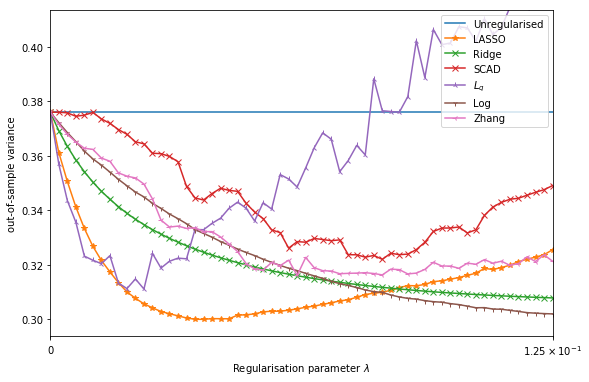

In [12]:
plt.figure(figsize=(9, 6))
fat_l = lambda_lasso_variances[0]*np.ones((1, len(lmbd))).T
plt.plot(lmbd, fat_l)
plt.plot(lmbd, lambda_lasso_variances, marker='*')
plt.plot(lmbd, lambda_ridge_variances, marker='x')
plt.plot(lmbd, lambda_scad_variances, marker='x')
plt.plot(lmbd, lambda_lq_variances, marker='2')
plt.plot(lmbd, lambda_log_variances, marker='1')
plt.plot(lmbd, lambda_zhang_variances, marker='3')
plt.legend([ 'Unregularised', 'LASSO', 'Ridge', 'SCAD', '$L_q$', 'Log', 'Zhang'], loc=1)
plt.ylim(top=1.1*lambda_lasso_variances[0])
#plt.ylim(bottom=0.28)
plt.xlim(right=lmbd[-1])
plt.xlim(left=lmbd[0])
plt.xlabel('Regularisation parameter $\lambda$')
plt.ylabel('out-of-sample variance')
plt.xscale('symlog')
plt.show()

In [13]:
print( min( lambda_lasso_variances ) )
print( min( lambda_ridge_variances ) )
print( min( lambda_scad_variances ) )
print( min( lambda_lq_variances ) )
print( min( lambda_log_variances ) )
print( min( lambda_zhang_variances ) )

[0.29994077]
[0.30781413]
[0.32198912]
[0.31107694]
[0.3019371]
[0.3160792]
